In [1]:
import os
import pandas as pd
import numpy as np
import scipy
import glob
import math
import matplotlib.pyplot as plt
from operator import *

import mne
from mne.preprocessing import ICA

from scipy.signal import butter, lfilter

import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Create custom Dataset object
class EEGDataset(Dataset):
    def __init__(self, eeglist, labels, transform=None, target_transform=None):
        self.labels = torch.from_numpy(np.array(labels))
        self.labels = self.labels.to(torch.float32)
        self.eeglist = eeglist
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        label = self.labels[idx]
        raw = self.eeglist[idx]
        eeg = torch.from_numpy(raw.get_data())
        eeg = eeg.to(torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return eeg, label

# Segment for preprocessed data from OpenNeuro was never used
data_list = {"raw":[], "preprocessed":[], "manual_preprocess":[]}
labels = []

# Pull patient labels and info from tsv file
readtsv = pd.read_csv('participants.tsv', sep = '\t')

channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
# Parse through data files and convert to Raw object to be processed
for i in range(1,89):
    curdir = os.getcwd()
    rawpath = curdir+ "\Raw Data\sub-%s\eeg"%(str(i).zfill(3))
    file = glob.glob(os.path.join(rawpath, '*.set'))
    raw = mne.io.read_raw_eeglab(file[0], preload = True)

    data_list['raw'].append(raw)
    
    #Pull labels from patient info tsv file
    label = readtsv['Group'][i-1]

    # One-hot encodings for labels
    if label == 'A':
        labels.append([0,0,1])
    elif label == 'F':
        labels.append([0,1,0])
    elif label == 'C':
        labels.append([1,0,0])



C:\Users\zha12433\AppData\Local\Temp\ipykernel_43968\2018944214.py:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  filtered = mne.io.read_raw_eeglab(filteredfile[0], preload = True)
C:\Users\zha12433\AppData\Local\Temp\ipykernel_43968\2018944214.py:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  filtered = mne.io.read_raw_eeglab(filteredfile[0], preload = True)
C:\Users\zha12433\AppData\Local\Temp\ipykernel_43968\2018944214.py:68: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  filtered = mne.io.read_raw_eeglab(filteredfile[0], preload = True)
C:\Users\zha12433\AppData\Local\Temp\ipykernel_43968\2018944214.py:68: RuntimeWarning: The data contains 'boundary' events, indicating data disco

In [2]:
from mne_icalabel import label_components
exclusion = ['line noise', 'heartbeat', 'eye blink']

# Define preprocessing function
def manual_process(raw, plotting = True):

    # Butterworth filter
    freq_low = 0.5
    freq_high = 100
    iirparams = dict(order = 4, ftype = 'butter') 
    raw.filter(freq_low, freq_high, method = 'iir', iir_params = iirparams)

    # Create ICA object and fit it to the data
    ica = ICA(n_components=19, random_state=97, verbose = False)
    ica.fit(raw)

    # Plot ICA components to identify artifacts
    icalabels = label_components(raw, ica, method = 'iclabel')
    if plotting == True:
        ica.plot_components()
        picks = list(range(0,18))
        ica.plot_properties(raw, picks=picks)
        print(icalabels)
    # Choose groupings to exclude
    ica.exclude = []
    for i, label in enumerate(icalabels):
        if label in exclusion:
            ica.exclude.append(i)
    # Apply exclusion
    ica.apply(raw)
            
    return raw

In [3]:
from IPython.display import clear_output 
# Process all raw data and append to list
for subject in data_list['raw']:
    raw = subject.copy().load_data()
    data_list['manual_preprocess'].append(manual_process(raw, plotting = False))
    clear_output()


In [4]:
import gc
gc.collect()

# Total minutes of data
totals = [485.5, 276.5, 402]

# Generate lists to hold Raw data objects
trainlist, vallist, testlist, trainlabels, vallabels, testlabels = [],[],[],[],[],[]

# One hot encodings
labelonehot = [[0,0,1], [0,1,0], [1,0,0]]

# Make sure enough of each group in each partition of data
for x, label in enumerate(labelonehot):
  count = 0
  for i in range (len(labels)):
    # Split based on class so each partition of data has sufficient data points in each class
    if labels[i] == label:
      m = 0
      while 15000*(m+1) < len(data_list['manual_preprocess'][i].copy().get_data()[0]):
        # Partition for training
        if totals[x]*2-count>100:
          n = data_list['manual_preprocess'][i].copy()
          trainlist.append(n.crop(m*30,(m+1)*30))
          trainlabels.append(labels[i])

        # Partition for validation (80 samples per class)
        if totals[x]*2-count>20:
          n = data_list['manual_preprocess'][i].copy()
          vallist.append(n.crop(m*30,(m+1)*30))
          vallabels.append(labels[i])
        
        # Partition for test (20 samples per class)
        else:
          n = data_list['manual_preprocess'][i].copy()
          testlist.append(n.crop(m*30, (m+1)*30))
          testlabels.append(labels[i])
        count = count + 1
        m = m+1

# Create custom dataset objects
trainset = EEGDataset(trainlist, trainlabels)
valset = EEGDataset(vallist, vallabels)
testset = EEGDataset(testlist, testlabels)

# Transfer dataset objects into dataloaders
trainloader = DataLoader(trainset, batch_size = 64, shuffle = True)
valloader = DataLoader(valset, batch_size = 64, shuffle = True)
testloader = DataLoader(testset, batch_size = 64, shuffle = True)


In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Some of the different model architectures we tried

class CNN_EEG_Classifier(nn.Module):
    def __init__(self, conv_kernel_size = 3, conv1_size = 25, conv2_size = 30, conv_stride = 1):
        super(CNN_EEG_Classifier, self).__init__()
        self.conv1_size = conv1_size
        self.conv2_size = conv2_size
        self.conv_kernel_size = conv_kernel_size
        #USE LARGER KERNEL BECAUSE IMAGES ARE HIGH RESOLUTION, FEATURES TAKE UP MORE PIXELS
        self.conv1 = nn.Conv1d(19, conv1_size, conv_kernel_size)
        #BATCH NORMALIZATION TO PREVENT VANISHING GRADIENTS
        self.bn1 = nn.BatchNorm1d(conv1_size)
        #LARGE POOLING KERNEL TO REDUCE DIMENSIONALIZATION FASTER (JUST FOUND THIS TO BE HELPFUL BY EXPERIMENTING)
        self.pool = nn.MaxPool1d(4, 4)

        self.conv2 = nn.Conv1d(conv1_size, conv2_size, conv_kernel_size)
        
        self.bn2 = nn.BatchNorm1d(conv2_size)


        self.fc1 = nn.Linear(((15001-conv_kernel_size)//4-conv_kernel_size)//4*conv2_size, 256)
        self.fc2 = nn.Linear(256, 3)


    def forward(self, x):
        batch_size = x.shape[0]
        outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))
        outconv2 = outconv2.view(batch_size, -1)
        outfc1 = F.relu(self.fc1(outconv2))
        outfc2 = self.fc2(outfc1)
        out = F.softmax(outfc2, dim = 1)

        return out
class CNN_EEG_Classifier2(nn.Module):
    def __init__(self, conv_kernel_size = 3, conv1_size = 25, conv2_size = 30, conv3_size = 35, conv4_size = 40, conv5_size = 50, n = 2,conv_stride = 1):
        super(CNN_EEG_Classifier2, self).__init__()
        self.conv1_size = conv1_size
        self.conv2_size = conv2_size
        self.conv3_size = conv3_size
        self.conv4_size = conv4_size
        self.conv5_size = conv5_size
        self.n = n
        self.conv_kernel_size = conv_kernel_size
        #USE LARGER KERNEL BECAUSE IMAGES ARE HIGH RESOLUTION, FEATURES TAKE UP MORE PIXELS
        self.conv1 = nn.Conv1d(19, conv1_size, conv_kernel_size)
        #BATCH NORMALIZATION TO PREVENT VANISHING GRADIENTS
        self.bn1 = nn.BatchNorm1d(conv1_size)
        #LARGE POOLING KERNEL TO REDUCE DIMENSIONALIZATION FASTER (JUST FOUND THIS TO BE HELPFUL BY EXPERIMENTING)
        self.pool = nn.MaxPool1d(4, 4)

        self.conv2 = nn.Conv1d(conv1_size, conv2_size, conv_kernel_size)
        
        self.bn2 = nn.BatchNorm1d(conv2_size)
        self.conv3 = nn.Conv1d(conv2_size, conv3_size, conv_kernel_size)
        self.bn3 = nn.BatchNorm1d(conv3_size)
        self.conv4 = nn.Conv1d(conv3_size, conv4_size, conv_kernel_size)
        self.bn4 = nn.BatchNorm1d(conv4_size)
        self.conv5 = nn.Conv1d(conv4_size, conv5_size, conv_kernel_size)
        self.bn5 = nn.BatchNorm1d(conv5_size)
        self.linearinput = 15001
        for i in range(n):
            self.linearinput = (self.linearinput - conv_kernel_size)//4
        self.fc1 = nn.Linear(self.linearinput*conv5_size, 256)
        self.fc2 = nn.Linear(256, 3)


    def forward(self, x):
        batch_size = x.shape[0]
        outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))
        outconv3 = self.pool(F.relu(self.bn3(self.conv3(outconv2))))
        outconv4 = self.pool(F.relu(self.bn4(self.conv4(outconv3))))
        outconv5 = self.pool(F.relu(self.bn5(self.conv5(outconv4))))
        outconv5 = outconv5.view(batch_size, -1)
        outfc1 = F.relu(self.fc1(outconv5))
        outfc2 = self.fc2(outfc1)
        out = F.softmax(outfc2, dim = 1)

        return out
class CNN_EEG_Classifier3(nn.Module):
    def __init__(self, pooling_layers = [1,1,1,1,1],conv_kernel_size = 3, conv1_size = 25, conv2_size = 30, conv3_size = 35, conv4_size = 40, conv5_size = 50, n = 2,conv_stride = 1):
        super(CNN_EEG_Classifier3, self).__init__()
        self.conv1_size = conv1_size
        self.conv2_size = conv2_size
        self.conv3_size = conv3_size
        self.conv4_size = conv4_size
        self.conv5_size = conv5_size
        self.pooling_layers = pooling_layers
        self.n = n
        self.conv_kernel_size = conv_kernel_size
        #USE LARGER KERNEL BECAUSE IMAGES ARE HIGH RESOLUTION, FEATURES TAKE UP MORE PIXELS
        self.conv1 = nn.Conv1d(19, conv1_size, conv_kernel_size)
        #BATCH NORMALIZATION TO PREVENT VANISHING GRADIENTS
        self.bn1 = nn.BatchNorm1d(conv1_size)
        #LARGE POOLING KERNEL TO REDUCE DIMENSIONALIZATION FASTER (JUST FOUND THIS TO BE HELPFUL BY EXPERIMENTING)
        self.pool = nn.MaxPool1d(4, 4)

        self.conv2 = nn.Conv1d(conv1_size, conv2_size, conv_kernel_size)
        
        self.bn2 = nn.BatchNorm1d(conv2_size)
        self.conv3 = nn.Conv1d(conv2_size, conv3_size, conv_kernel_size)
        self.bn3 = nn.BatchNorm1d(conv3_size)
        self.conv4 = nn.Conv1d(conv3_size, conv4_size, conv_kernel_size)
        self.bn4 = nn.BatchNorm1d(conv4_size)
        self.conv5 = nn.Conv1d(conv4_size, conv5_size, conv_kernel_size)
        self.bn5 = nn.BatchNorm1d(conv5_size)
        self.linearinput = 15001
        for num in pooling_layers:
            if num == 1:
                self.linearinput = (self.linearinput - conv_kernel_size)//4
        self.fc1 = nn.Linear(self.linearinput*conv5_size, 256)
        self.fc2 = nn.Linear(256, 3)


    def forward(self, x):
        batch_size = x.shape[0]
        if self.pooling_layers[0] == 1:
            outconv1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        else:
            outconv1 = F.relu(self.bn1(self.conv1(x)))
        if self.pooling_layers[1] == 1:
            outconv2 = self.pool(F.relu(self.bn2(self.conv2(outconv1))))
        else:
            outconv2 = F.relu(self.bn2(self.conv2(outconv1)))
        if self.pooling_layers[2] == 1:
            outconv3 = self.pool(F.relu(self.bn3(self.conv3(outconv2))))
        else:
            outconv3 = F.relu(self.bn3(self.conv3(outconv2)))
        if self.pooling_layers[3] == 1:
            outconv4 = self.pool(F.relu(self.bn4(self.conv4(outconv3))))
        else:
            outconv4 = F.relu(self.bn4(self.conv4(outconv3)))
        if self.pooling_layers[4] == 1:
            outconv5 = self.pool(F.relu(self.bn5(self.conv5(outconv4))))
        else:
            outconv5 = F.relu(self.bn5(self.conv5(outconv4)))
        outconv5 = outconv5.view(batch_size, -1)
        outfc1 = F.relu(self.fc1(outconv5))
        outfc2 = self.fc2(outfc1)
        out = F.softmax(outfc2, dim = 1)

        return out
class CNN_EEG_Classifier_5Layer(nn.Module):
    def __init__(self, dropoutsize):
        super(CNN_EEG_Classifier_5Layer, self).__init__()
        
        conv_size = [25, 30, 35,40,45]
        conv_stride = [2, 2, 2,2,2]
        conv_kernel_size = [4, 4, 4,4,4]
        n_layers = len(conv_size)
        
        pool_kernel = [4, 1, 1,1,4]
        pool_stride = [4, 1, 1,1,4]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])
        
        self.conv4 = nn.Conv1d(conv_size[2], conv_size[3], conv_kernel_size[3], conv_stride[3])
        self.bn4 = nn.BatchNorm1d(conv_size[3])
        self.pool4 = nn.MaxPool1d(pool_kernel[3], pool_stride[3])

        self.conv5 = nn.Conv1d(conv_size[3], conv_size[4], conv_kernel_size[4], conv_stride[4])
        self.bn5 = nn.BatchNorm1d(conv_size[4])
        self.pool5 = nn.MaxPool1d(pool_kernel[4], pool_stride[4])
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  
        
        linear1_size = int(size*conv_size[n_layers-1])
        self.fc1 = nn.Linear(linear1_size, 500)
        self.fc2 = nn.Linear(500, 100)
        self.dropout1 = nn.Dropout(dropoutsize)
        self.fc3 = nn.Linear(100, 3)



    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # print(outconv1.shape)
        outconv2 = self.pool2(F.relu(self.bn2(self.conv2(outconv1))))
        # print(outconv2.shape)
        outconv3 = self.pool3(F.relu(self.bn3(self.conv3(outconv2))))
        # print(outconv3.shape)
        outconv4 = self.pool4(F.relu(self.bn4(self.conv4(outconv3))))
        outconv5 = self.pool5(F.relu(self.bn5(self.conv5(outconv4))))
        outconv5 = outconv5.view(batch_size, -1)

        outfc1 = self.dropout1(F.relu(self.fc1(outconv5)))

        outfc2 = (self.fc2(outfc1))

        outfc3 = F.relu(self.fc3(outfc2))
        out = F.softmax(outfc3, dim = 1)

        return out
class CNN_EEG_Classifier_3cnn_medium_kernel(nn.Module):
    def __init__(self):
        """Trying kernel size 3 with 3 CNN model"""
        super(CNN_EEG_Classifier_3cnn_medium_kernel, self).__init__()
        
        
        conv_size = [25, 30, 35]
        conv_stride = [1, 1, 1]
        conv_kernel_size = [3, 3, 3]
        n_layers = len(conv_size)
        
        pool_kernel = [1, 4, 1]
        pool_stride = [1, 4, 1]
        
        
        self.conv1 = nn.Conv1d(19, conv_size[0], conv_kernel_size[0], conv_stride[0])
        self.bn1 = nn.BatchNorm1d(conv_size[0])
        self.pool1 = nn.MaxPool1d(pool_kernel[0], pool_stride[0])

        self.conv2 = nn.Conv1d(conv_size[0], conv_size[1], conv_kernel_size[1], conv_stride[1])
        self.bn2 = nn.BatchNorm1d(conv_size[1])
        self.pool2 = nn.MaxPool1d(pool_kernel[1], pool_stride[1])

        self.conv3 = nn.Conv1d(conv_size[1], conv_size[2], conv_kernel_size[2], conv_stride[2])
        self.bn3 = nn.BatchNorm1d(conv_size[2])
        self.pool3 = nn.MaxPool1d(pool_kernel[2], pool_stride[2])
        
        size = 15001
        for i in range(n_layers):
            size = ((size-conv_kernel_size[i])/conv_stride[i]) + 1
            size = ((size - pool_kernel[i])//pool_stride[i]) + 1  

        linear1_size = int(size*conv_size[n_layers-1])
        self.fc1 = nn.Linear(linear1_size, 7500)
        self.fc2 = nn.Linear(7500, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.dropout1 = nn.Dropout(0.75)
        self.fc4 = nn.Linear(100, 3)
    def forward(self, x):
        batch_size = x.shape[0]
        outconv1 = self.pool1(F.relu(self.bn1(self.conv1(x))))
        outconv2 = self.pool2(F.relu(self.bn2(self.conv2(outconv1))))
        outconv3 = self.pool3(F.relu(self.bn3(self.conv3(outconv2))))
        outconv3 = outconv3.view(batch_size, -1)
        outfc1 = (F.relu(self.fc1(outconv3)))
        outfc2 = (self.fc2(outfc1))
        outfc3 = self.dropout1(F.relu(self.fc3(outfc2)))
        outfc4 = self.fc4(outfc3)
        out = F.softmax(outfc4, dim = 1)

        return out


In [6]:
import torch.optim as optim
import time

# Evaluation code
def get_accuracy(model, train=True, train_data = trainloader, val_data = valloader):
    if train:
        dataloader = train_data
    else:
        dataloader = val_data
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            outputs = model(imgs.float())
            predicted = torch.argmax(outputs, dim=1)
            _, labels = torch.max(labels, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total
torch.manual_seed(5)

# Training code with SGD optimizer
def trainsgd(model,batch_size=1, traindata = trainloader, valdata = valloader, num_epochs=10, rate = 0.001, name = 'model', adaptive = None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(traindata):
            
            # print(imgs.shape)
            imgs = imgs.to(torch.float32)
            out = model(imgs)             # forward pass
            # print(out.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            if adaptive == 'linear':
                rate = rate*0.90
            if adaptive == 'step':
                if epoch%4 == 0:
                    rate = rate*0.1
            
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True, train_data=traindata)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False, val_data = valdata))  # compute validation accuracy
            n += 1
        print("Epoch:", epoch)
        print("Training Accuracy:", train_acc[-1])
        print("Validation Accuracy:", val_acc[-1])

    print("Iterations:", n)
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.savefig("traincurve1batch%depochs%d%s.png"%(batch_size, num_epochs, name))
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')

    plt.savefig("traincurve2batch%depochs%d%s.png"%(batch_size, num_epochs,name))
    plt.show()
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    testacc = get_accuracy(model,train = True, train_data = testloader)
    f = open('results.txt', "a")
    f.write('\n%s model with %d batch size and %d epochs had a final validation accuracy of %f and a validation accuracy of %f.\nThe test accuracy was: %f'%(name,batch_size, num_epochs, train_acc[-1], val_acc[-1],testacc))
    f.close()
    clear_output()

# Training code using Adam optimizer
def trainadam(model,batch_size=1, traindata = trainloader, valdata = valloader, num_epochs=10, rate = 0.001, name = 'model', adaptive = None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(traindata):

            # print(imgs.shape)
            imgs = imgs.to(torch.float32)
            out = model(imgs)             # forward pass
            # print(out.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            if adaptive == 'linear':
                rate = rate*0.90
            if adaptive == 'step':
                if epoch%4 == 0:
                    rate = rate*0.1
            
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True, train_data=traindata)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False, val_data = valdata))  # compute validation accuracy
            n += 1
        print("Epoch:", epoch)
        print("Training Accuracy:", train_acc[-1])
        print("Validation Accuracy:", val_acc[-1])

    print("Iterations:", n)
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.savefig("traincurve1batch%depochs%d%s.png"%(batch_size, num_epochs, name))
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')

    plt.savefig("traincurve2batch%depochs%d%s.png"%(batch_size, num_epochs,name))
    plt.show()
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    testacc = get_accuracy(model,train = True, train_data = testloader)
    f = open('results.txt', "a")
    f.write('\n%s model with %d batch size and %d epochs had a final validation accuracy of %f and a validation accuracy of %f.\nThe test accuracy was: %f'%(name,batch_size, num_epochs, train_acc[-1], val_acc[-1],testacc))
    f.close()
    clear_output()



In [ ]:
bestacc = 0
for i in range (20):
    CNN1 = CNN_EEG_Classifier2(conv1_size=25, conv2_size=30, conv3_size = 35,conv4_size = 40, conv5_size = 45, n = 5)
    trainsgd(CNN1, batch_size = 64, num_epochs = 20, rate = 0.1, name = '5layerbestsgd%d'%i)
    acc = get_accuracy(CNN1, train = True, train_data=testloader)
    if acc >bestacc:
        bestacc = acc
        torch.save(CNN1, 'curbest.pt')
    print('Current best accuracy:', bestacc)


Accuracy is: 70.0


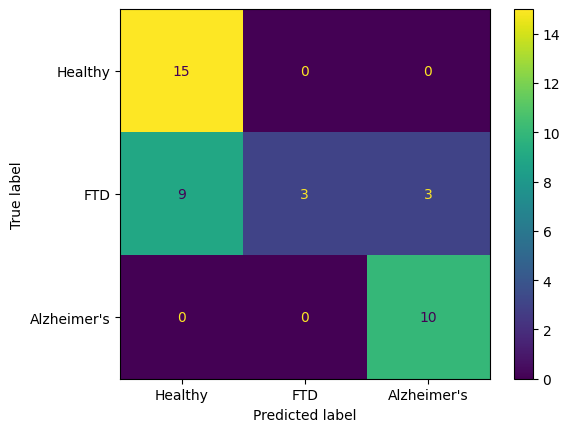

      Predicted       Actual
0       Healthy      Healthy
1       Healthy          FTD
2       Healthy      Healthy
3   Alzheimer's  Alzheimer's
4           FTD          FTD
5       Healthy          FTD
6   Alzheimer's  Alzheimer's
7       Healthy          FTD
8       Healthy      Healthy
9       Healthy      Healthy
10      Healthy      Healthy
11  Alzheimer's          FTD
12  Alzheimer's  Alzheimer's
13      Healthy          FTD
14  Alzheimer's  Alzheimer's
15          FTD          FTD
16      Healthy      Healthy
17  Alzheimer's  Alzheimer's
18      Healthy      Healthy
19      Healthy      Healthy
20      Healthy      Healthy
21  Alzheimer's  Alzheimer's
22      Healthy      Healthy
23  Alzheimer's  Alzheimer's
24      Healthy          FTD
25          FTD          FTD
26      Healthy          FTD
27      Healthy      Healthy
28      Healthy          FTD
29      Healthy          FTD
30  Alzheimer's  Alzheimer's
31  Alzheimer's  Alzheimer's
32      Healthy          FTD
33  Alzheimer'

In [38]:
from sklearn import metrics

#Load in saved best model
model = torch.load('curbest.pt')
diagnosis, condition = [],[]
print("Accuracy is:", get_accuracy(model, train = True, train_data=testloader))

# Outputs of 0, 1, and 2 correspond to healthy, FTD and Alzheimer's groups respectively
for imgs, labels in testloader:
    outputs = model(imgs.float())
    predicted = torch.argmax(outputs, dim=1)      
    _, actual = torch.max(labels, dim=1)

# Generate confusion matrix
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Healthy', 'FTD', "Alzheimer's"])
cm_display.plot()
plt.show()

# Change numerical labels to actual diagnoses
for i in range(len(predicted)):
    if predicted[i] == 0:
        diagnosis.append('Healthy')
    elif predicted[i] == 1:
        diagnosis.append('FTD')
    elif predicted[i] == 2:
        diagnosis.append("Alzheimer's")

    if actual[i] == 0:
        condition.append('Healthy')
    elif actual[i] == 1:
        condition.append('FTD')
    elif actual[i] == 2:
        condition.append("Alzheimer's")

# Print results
results = pd.DataFrame(np.array([diagnosis, condition])).transpose()
results.columns = ['Predicted', 'Actual']
print(results)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# ANN baseline model
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(19*10001, 5000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5000, 300)
        self.fc3 = nn.Linear(300,3)

    def forward(self, x):
        x = x.view(-1, 19*10001)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


# Define hyperparameters
hidden_size = 19
learning_rate = 0.001
num_epochs = 50
batch_size = 2

# Initialize the ANN model
model = ANN(30001, hidden_size, 3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in trainloader:
        # Forward pass
        inputs = inputs.to(torch.float32)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # Print average loss for this epoch
    epoch_loss = running_loss / len(trainloader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluation
# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for imgs, labels in testloader:
        outputs = model(imgs)
        predicted = torch.argmax(outputs, dim=1)
        _, labels = torch.max(labels, dim=1)
        # print(predicted, labels)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.4f}')

